# Robot Navigation Statistics

This Jupyter notebook contains code which reads in and explores the dataset we discussed in the seminar: navigation data from a mobile robot navigating in an office environment. You should read through the notebook and run each cell in turn. Try to best to understand the code as you run it, since your tasks will require you to alter and resuse it. 

Before goingn further we'll import some common maths and plotting libraries. If this step fails, please refer to the supporting material you were previously sent.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The first thing we need to do is to read in the data set from the comma-separated values (csv) files. This uses the built-in csv functionality in Python, combined with file reading. When the file is read in all the values are read in as strings. To allow us to work with the data, we convert the data row-by-row into the native types. The `convert_row` method is specific to the data in this exercise. If you wish to use this approach for subsequent exercises you can copy this code and change the `convert_row` as appropriate.

In [3]:
import csv
from datetime import datetime

def convert_row(row):
    """
    Take a row and convert the values to the known data types.
    """
#     duration is in seconds
    row['operation_time'] = float(row['operation_time'])
    row['time_to_waypoint'] = float(row['time_to_waypoint'])
#     dates are converted to datetime objects
    row['date_started'] = datetime.strptime(row['date_started'], '%Y-%m-%d %H:%M:%S')
    row['date_at_node'] = datetime.strptime(row['date_at_node'], '%Y-%m-%d %H:%M:%S')
    row['date_finished'] = datetime.strptime(row['date_finished'], '%Y-%m-%d %H:%M:%S')
# status of result is converted from a string/integer into a boolean 
    row['status_bin'] = (row['status_bin'] == '1')
    
    
def read_records(filename):
    """
    Read a CSV file into a list of dictionaries, where each 
    dictionary has keys taken from the column names in the file.
    """
    records = []
    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            convert_row(row)            
            records.append(row)

    return records

Now we use the above code to read in the navigation data from the csv file supplied

In [4]:
data = read_records('../data/tsc_y3_nav_stats.csv')
print('Read in {} records'.format(len(data)))


Read in 12648 records


And we can take a look at the first entry in the data set. We do this by printing the first element of the list `data` which contains all the data we read in.

In [5]:
print(data[0])

{'date_started': datetime.datetime(2016, 5, 23, 18, 45, 47), 'status': 'success', 'origin': 'WayPoint46', 'target': 'WayPoint39', 'final_node': 'WayPoint39', 'edge_id': 'WayPoint46_WayPoint39', 'date_finished': datetime.datetime(2016, 5, 23, 18, 46, 2), 'date_at_node': datetime.datetime(2016, 5, 23, 18, 45, 56), 'operation_time': 14.547985, 'time_to_waypoint': 5.41281, 'status_bin': True}


This shows us the general structure of the data. Each data point is a sample of an attempt to navigate a edge in the robot's topological map. This is indicated by the `edge_id`. The navigation attempt starts from the `origin` node with the aim of reaching `target`. It may successfully reach that node, or it may end up somewhere else. The place it ends up is `final_node`. Each node is a 2D point plus an *influence zone* which is an area around that point. The `operation_time` field indicates the duration (in seconds) of the navigation action until the influence zone is reached. The `time_to_waypoint` is the time spend in the navigation action after the influence zone is reached until the action is terminated. Termination conditions may be the robot reaching the 2D waypoint for the node, having a new action superseding the current one, or failing (in which case the action is cancelled by another process due to a timeout or another failure condition). These durations can be matched to the dates as follows, `operation_time = date_finished - date_started`, `time_to_waypoint = date_finished - date_at_node` but they were  recorded with sub-second accuracy.

# Data Overview

When working with data, it is important to start by getting a general sense of the nature of that data. We can start by asking how many times each edge was traversed. We will do this by grouping the dataset by `edge_id`. The code below creates a dictionary where each value is a list of data entries, and the key for that entry is the value of the field. 


In [6]:
def group_data_by_field(datalist, field):
    """
    Given a list of dictionaries, return a dictionary of lists where each sublist contains all dictionaries with the same value of that field, and the key of that entry is that value.
    """
    output = dict()
    for d in datalist:
        # get the value of the field for this entry
        field_value = d[field]
        # if this value has not been seen before, create a new output entry for it
        if field_value not in output:
            output[field_value] = []
        # append the entry to the list for this field value
        output[field_value].append(d)
    return output
        

We now use this function to group the data by `edge_id`, so the result will be a mapping from each `edge_id` to a list of the data entries for that id.

In [7]:
edge_groups = group_data_by_field(data, 'edge_id')

Let's now count now many nav stats (i.e. data entries) we have for each edge. We'll do this by creating a new dictionary that maps from edge ids to counts. Before looking at the code below feel free to attempt this yourself, or at least consider how you would need to implement it.


In [8]:
edge_counts = dict()
for edge_id, stat_list in edge_groups.items():
    edge_counts[edge_id] = len(stat_list)    

We can also write the same code in one line using a *dictionary comprehension* as follows

In [9]:
edge_counts = {edge_id: len(stat_list) for edge_id, stat_list in edge_groups.items()}

This allows us to query the data for the number of data points per edge, e.g.

In [10]:
'Edge {} has {} entries'.format('SuppPrintCopy_SuppLocker6', edge_counts['SuppPrintCopy_SuppLocker6'])

'Edge SuppPrintCopy_SuppLocker6 has 3 entries'

More usefully, we can visualise the count data as a histgram. To do this we'll need paired lists of edge IDs and counts. 

In [11]:
edge_ids = list(edge_counts.keys())
counts  = list(edge_counts.values())

<BarContainer object of 450 artists>

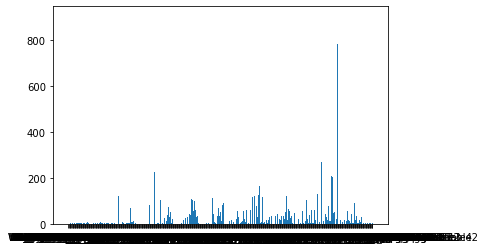

In [12]:
plt.bar(edge_ids, counts)

That's a bit ugly. To make it easier to extract information from, let's start by sorting the data. First we produce a list of (edge_id, count) pairs, then we sort that list. We can verify that this has worked as expected by printing the first and lest element of the list.

In [13]:
edge_count_list = [(edge_id, len(stat_list)) for edge_id, stat_list in edge_groups.items()]
edge_count_list.sort(key=lambda x:x[1], reverse=True)
print(edge_count_list[0], edge_count_list[-1])


('SuppLocker13_SuppLocker14', 901) ('NarrowGlass2_CorpTransWP3', 1)


We then need to extract the first element of every pair (a pair is also called a tuple) back into a list of edge ids, and a the second elements into the count list.

In [14]:
edge_ids = []
counts = []
for tupl in edge_count_list:
    edge_ids.append(tupl[0])
    counts.append(tupl[1])

We could also do this by unpacking the pairs and using the built in `zip` function to create the two lists we want for plotting. This is less easy to read but is a good example of some in-build Python functionality.
    

In [15]:
zipped_list = list(zip(*edge_count_list))
edge_ids = zipped_list[0]
counts = zipped_list[1]

Whichever way we create the lists, we can now produce a bar chart that looks a bit cleaner. We'll also remove the labels from the x axis, which are impossible to read anyway.

Text(0.5, 1.0, 'Edge data counts')

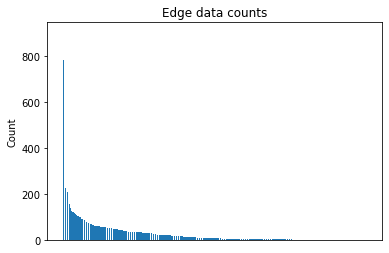

In [16]:
plt.bar(edge_ids, counts)
plt.xticks([])
plt.ylabel('Count')
plt.title('Edge data counts')

There are clearly some interesting edges which have significantly more visits than the the others. Let's look at the top 10.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

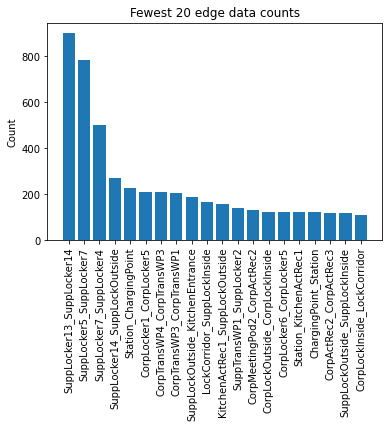

In [18]:
# Sorting out the fewest 20 dp

edge_ids = edge_ids[:20]
counts = counts[:20]
plt.bar(edge_ids, counts)

plt.ylabel('Count')
plt.title('Fewest 20 edge data counts')
plt.xticks(rotation=90)

## Tasks

Write code to complete as many of the following tasks as you want. You may use external libraries (e.g. numpy) if you wish.
1. Print out the edges with the maximum and minimum number of visits.
1. Plot a histogram with the 20 fewest datapoints.
1. Determine the mean, median, and mode number of nav stats per edge.
1. Adapt the histograph above so that each bar has a green part for the count of successful navigation actions, and a red part for a count of the unsuccessful ones. You can use the `status_bin` field for this.



# Edge Durations

When we are using this navigation data to build a Markov decision process to plan robot navigation routes, we are interested in two properties of this data: the duration of the navigation action, and whether the action is likely to succeed or not. We can now move on to looking at these features of each edge. 


To start with we'll build a list of (operation_time, operation_succeeded) pairs for every action on each edge. This will allow us to consider that data together more easily later.

In [19]:
edge_operation_data = dict()

for edge_id, rows in edge_groups.items():    
    edge_operation_data[edge_id] = [(r['operation_time'], r['date_started'], r['status_bin']) for r in rows]
    

Next, let's choose an edge to focus on for some analysis. Focussing on one part of your dataset can allow you get a better handle on your dataset, but be careful not to make unwarranted generalisations to other parts. In this case we're going to focus on one of the edges with lots of data, 'SuppLockOutside_KitchenEntrance'.

In [20]:
focus_edge = 'SuppLockOutside_KitchenEntrance'

To get an initial feel for the operation duration data on this edge, let's start by plotting a histogram of the operation times. matplotlib can do this for us automatically, and we can choose how many bins we have for the data.

Text(0.5, 0, 'Operation Duration (secs)')

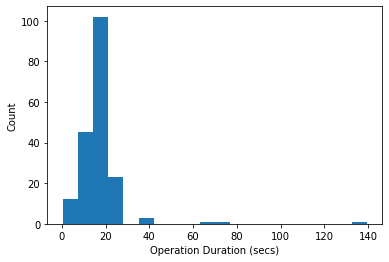

In [21]:
# as above, extract a new list containing the 0th element of every tuple in edge_operation_data
zip_list = list(zip(*edge_operation_data[focus_edge]))
durations = list(zip_list[0])
# plot the durations
plt.hist(durations, bins=20)
plt.ylabel('Count')
plt.xlabel('Operation Duration (secs)')


This shows what you may expect to find in such data: the majority of the durations are clustered around a small range. This probably represents the robot having a relatively stress-free time when navigating. We also see some *outliers*, i.e. data that falls outside the range where the majority of the data lies. Since the histogram doesn't really allow us to see how many datapoints are in this 'tail', let's plot the operation times against the time they occurred. This second variable isn't important (for now), but it allows us to spread the data out naturally.

Text(0, 0.5, 'Duration (secs)')

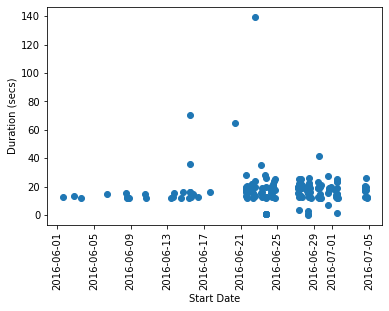

In [22]:
dates = list(zip_list[1])

plt.scatter(dates, durations)
plt.xticks(rotation=90)
plt.xlabel('Start Date')
plt.ylabel('Duration (secs)')

This more clearly shows the outliers. Since we are working with a research (i.e. bug-ridden) autonomous robot in a human-populated environment, it is likely that there were some unexpected outcomes from the navigation actions, such as component malfunctions, or humans actively trying to slow the robot down. Therefore we shall take a common approach in data science and filter out the outliers. We will do this by throwing away (or filtering out) any value that is more than some number (e.g. 3) standard deviations away from the mean of the dataset. The function below does this for a list of values (which will be durations), and a paired second list (the dates). 


In [23]:
def remove_outliers(values, other, n_std=3):
    """
    Remove outlier values from the values and other list. 
    
    Outliers are defined as n_std standard deviations from the mean
    """
    mean = np.mean(values)
    stdev = np.std(values)
    
    print('The data has mean', mean, 'seconds, with a standard deviation of', stdev)

    # these are going to be items we need to remove from the list
    indexes_to_remove = []

    # bonus points for anyone that works out why "reversed" is needed here

    # for each duration
    for i in reversed(range(len(values))):
        value = values[i]
        # check if the values is greater than two standard deviations from the mean
        if np.abs(value - mean) > (stdev*n_std):
            indexes_to_remove.append(i)

    # delete the elements we don't want      
    for i in indexes_to_remove:
        del values[i]
        del other[i] 

Next we apply this function to the data we used for the scatter plot, navigation durations and their dates.

In [24]:
remove_outliers(durations, dates)

The data has mean 18.092935776595745 seconds, with a standard deviation of 11.934341397241583


We can now plot the data with the out-of-distribution values removed. 

Text(0, 0.5, 'Duration (secs)')

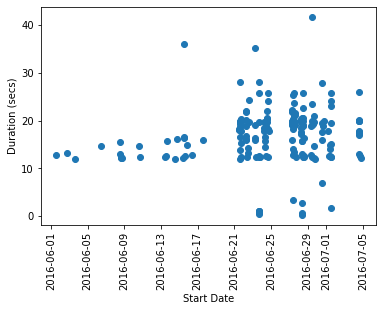

In [25]:
plt.scatter(dates, durations)
plt.xticks(rotation=90)
plt.xlabel('Start Date')
plt.ylabel('Duration (secs)')

This now looks a lot better since we've got ride of some of the very high values that looked to be due to very unexpected robot behaviour or environment configurations. But was that the right thing to do? At this point it's important to bring in some understanding of the process which generated the data. When a robot navigates we expect some variation in duration, and occasionally we expect large variations due to people moving around the robot, or possibly hardware or software failures. When we filtered out large values we assumed that all these conditions should follow the same distribution (i.e. be based around the same mean), but is that a valid assumption? My answer is no. We can check this by scattering the data again, but this time colouring the failed transitions differently to the successful ones.

To do this we can go back through the data and build two lists: succeeded navigations and failed ones.

In [26]:
successful_durations = []
failed_durations = []
successful_dates = []
failed_dates = []

# for each (operation_time, date, success) tuple
for tupl in edge_operation_data[focus_edge]:
    # if stat was a success
    if tupl[2]:
        successful_durations.append(tupl[0])
        successful_dates.append(tupl[1])
    else:
        failed_durations.append(tupl[0])
        failed_dates.append(tupl[1])
    

Now we can plot this two lists separately

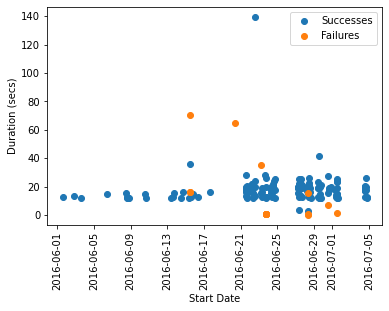

In [27]:
plt.scatter(successful_dates, successful_durations, label='Successes')
plt.scatter(failed_dates, failed_durations, label='Failures')
plt.xticks(rotation=90)
plt.xlabel('Start Date')
plt.ylabel('Duration (secs)')
plt.legend()

The results are quite striking! The failures appear to follow quite a different distribution to the successes. Failures can take much longer than successes (e.g. as the robot repeatedly tries to pass an obstacle) but can also be quicker (as some catesrophic condition is encountered). The success value that is around 140 seconds does look like a true oulier, we should reapply our filtering to each distribution separately.

In [28]:
remove_outliers(successful_durations, successful_dates)
remove_outliers(failed_durations, failed_dates)


The data has mean 18.41138783139535 seconds, with a standard deviation of 10.436509071708924
The data has mean 14.669576187499999 seconds, with a standard deviation of 22.13204926958299


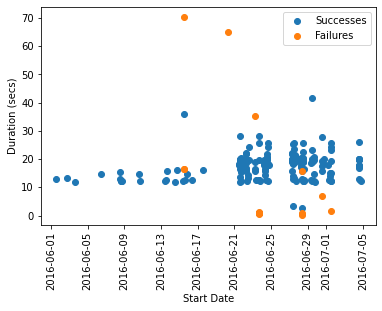

In [29]:
plt.scatter(successful_dates, successful_durations, label='Successes')
plt.scatter(failed_dates, failed_durations, label='Failures')
plt.xticks(rotation=90)
plt.xlabel('Start Date')
plt.ylabel('Duration (secs)')
plt.legend()

This results reflects reality a bit better. The successes are reasonably tightly distributed, but the failures are more widely spread. One curious fact remains: there are two very quick successes. Given this is a physical device with a fixed top speed, there should be a minimum successful duration. This appears to be a touch over 10 seconds from the plot. I would therefore also be tempted to filter out unrealistically fast points from this dataset too.

If you recall from the seminar, we are processing this data in order to plan future actions of the robot. In order to do that we must *generalise* from the data we have observed in order to *predict* future navigation outcomes. This is beyond the scope of this session, but I will provide one example of how to do it. To build a Markov decision process that models time, we want to predict the *probability* of a particular duration occurring. If we want a discrete model we can use normalise our earlier histogram plot such that the sum of all counts is 1. This turns it into a probability distribution. If we want a continuous distribuion, we must perform something called *density estimation* which estimate a continuous probabilitiy density function from a set of samples. Examples of applying both of these processes are presented below.

Text(0, 0.5, 'Probability of Duration P(D) ')

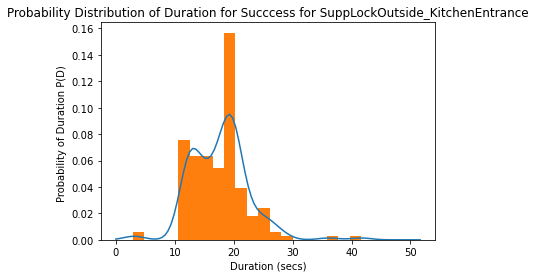

In [30]:
from scipy import stats

# create a kernel density estimator for the data
kde = stats.gaussian_kde(successful_durations)

# define the linear space over which we will plot the output
xs = np.linspace(0, np.max(successful_durations)+10, num=100)
# evaluate the probability density value over the output space
y = kde(xs) 
# plot the estimation
plt.plot(xs, y)
# overlay the probability distribution histogram
plt.hist(successful_durations, density=True, bins=20)
plt.title('Probability Distribution of Duration for Succcess for {}'.format(focus_edge) )
plt.xlabel('Duration (secs)')
plt.ylabel('Probability of Duration P(D) ')
           

This plot captures the intuition we've been following: values outside of range 10-30 are highly unlikely. There is also an interesting feature that was not visible on the earlier histogram: the success duration appears to have two *modes*, or two peaks in the distribution. This could reflect something about the physical process, e.g. that there are two different routes the robot follows between these edges, or that the faster mode occurs when the space unpopulated by pesky humans.

## Tasks

Write code to complete as many of the following tasks as you want. You may use external libraries (e.g. numpy, scipy) if you wish. The tasks are presented in increasing difficulty. I hope that every attempts at least the first one or two.

1. Find the edges in the dataset with the lowest and highest mean operation time, calculated over both successful and failed actions (this is known as the expected duration of the edge).  As a hint you should start with a for loop over the items in `edge_operation_data` dictionary. Inside that loop you should include some of the operations I wrote in separate cells above (e.g. extracting all the durations, calculating their mean, etc). 
1. Find the edges in the dataset with the lowest and highest success rate, i.e. the ratio of successful to failed statistics. This can be considered the (frequentist) probability of success for that edge. 
1. Design a way to determine if two edges are similar to each other, e.g. using some of the measures of duration and success we've used previously.
1. Using this measure, produce a ranked list of the most similar edges. Are edges that join the same two nodes but in opposite directions similar?


More open-ended, challenging tasks for those more comfortable with Python and/or statistics. These are not in any particular order.

1. Find more edges with suspicious successes (e.g. highly unlikely fast successes). 
1. Find more edges with multiple modes in their duration data, e.g. by looking at the rate of change of the y values in the density estimation.
1. Explore the difference between operation_time and time_to_waypoint. Do you see any interesting patterns?
1. Is there any dependency between time of day or day of the week and operation time or success rate?
